#### From https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

- Fast data download

In [4]:
! mkdir ../data
! curl -L -o ../data/data.zip  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud
! unzip ../data/data.zip -d ../data/
! mv ../data/creditcard.csv ../data/data.csv

mkdir: cannot create directory ‘../data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  7490k      0  0:00:09  0:00:09 --:--:-- 6116k
Archive:  ../data/data.zip
  inflating: ../data/creditcard.csv  


# Credit Card Fraud Detection

### SEVERAL CHARACTERISTICS ABOUT THE DATASET
- Highly unbalanced
- Features are under PCA transformation
- Unknown and hidden features

### TERMINAL INSTALLATION

In [ ]:
# !pip install imbalanced-learn

### PACKAGES

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pprint import pprint

### UTILS

In [9]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(2))
        
def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

### LOAD THE DATASET AND SIMPLE PREPROCESSING

- Load the dataset

In [6]:
df = pd.read_csv(filepath_or_buffer="../data/data.csv")
print_df(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


- Check for na values

In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### DATA VISUALIZATION

- Class distribution

In [3]:
counts = df["Class"].value_counts()
print(counts)

Class
0    284315
1       492
Name: count, dtype: int64


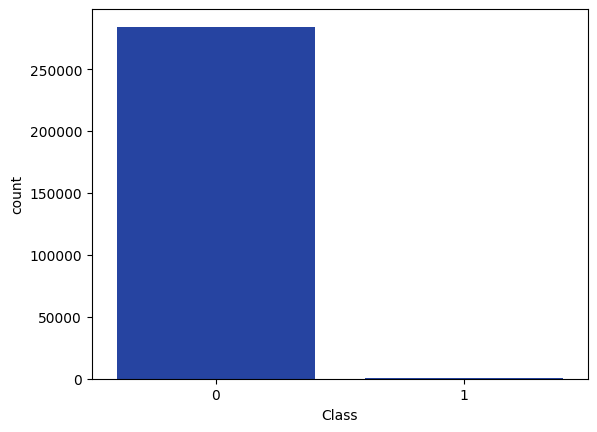

In [10]:
# imbalanced dataset
sns.countplot(data=df, x="Class", color=random_color())

plt.show()

- Amount distribution given the class

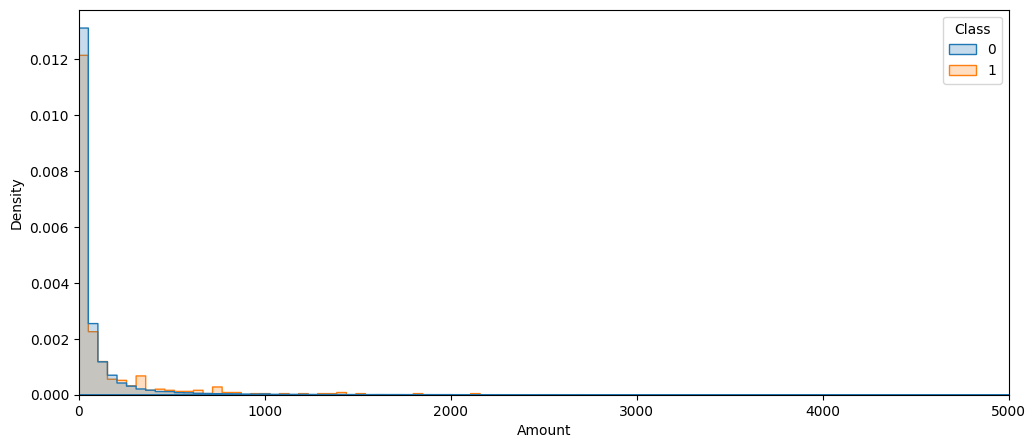

In [16]:
plt.figure(figsize=(12,5))
sns.histplot(data=df, x='Amount', hue='Class', element='step', stat='density', common_norm=False, bins=500)
plt.xlim((0, 5000))
plt.xlabel('Amount')
plt.show()


- Distribution of V# given the class?

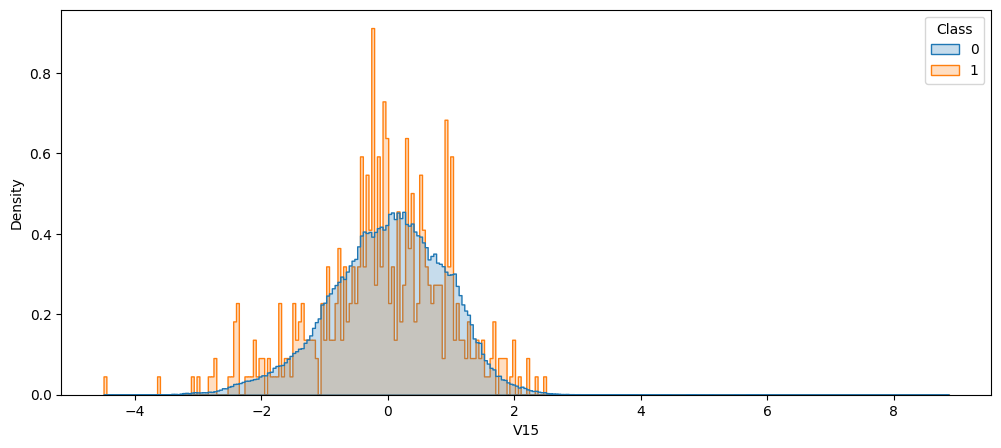

In [37]:
plt.figure(figsize=(12,5))
sns.histplot(data=df, x='V15', hue='Class', element='step', stat='density', common_norm=False, bins=300)
plt.xlabel('V15')
plt.show()

### USE K-FOLD CROSS VALIDATION (ORDER IS IMPORTANT)

- Candidate models

In [46]:
MODELS = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "XGB" : xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='logloss', random_state=42,),
    "NB": GaussianNB(),
    "RF": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced'),
    "SVM": SVC(random_state=42)
}
METRIC = "f1"
SCORES = {}

- Define the k-fold cross validation

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

- Split X and y (features and target)

In [48]:
y = df["Class"]
X = df.drop(columns=["Time", "Class"])

- Split the dataset into the train (for k-fold cross validation) and test set

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- Now for the train set, apply the k-fold cross validation, for each fold, apply the pipeline:
    - Scale Amount
    - SMOTE technique

- Feature columns

In [50]:
numeric_features = ["Amount"]
pca_features = [f"V{i}" for i in range(1, 29)]

- Scale the Amount column

In [51]:
preprocessor = ColumnTransformer(transformers=[
    ("amount_scaler", StandardScaler(), numeric_features)
], remainder="passthrough")

- The full pipeline for each fold

In [54]:
def get_pipeline(model):
    return Pipeline(
        steps=[
            # scale the Amount
            ("preprocesser", preprocessor),
            # resample the train set
            ("smote", SMOTE(random_state=42)),
            # train
            ("model", model)
        ]
    )

- For each model, try the k-fold cross validation (with fold with the pipeline), and return the most useful model

In [55]:
for name, model in MODELS.items():
    # each model, apply the 5-fold cross validation
    # each fold with the pipeline
    pipeline = get_pipeline(model)
    # run the 5-fold cross validation to get the average metric
    # each fold will be run with the pipeline
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=METRIC)
    
    # store the average metric from k-fold validation
    SCORES[name] = scores

pprint(SCORES)

{'LR': array([0.10610465, 0.1169687 , 0.10926366, 0.10034364, 0.10708899]),
 'NB': array([0.11119936, 0.10750853, 0.10577705, 0.11254753, 0.10534846]),
 'RF': array([0.8       , 0.80555556, 0.8137931 , 0.85714286, 0.84210526]),
 'SVM': array([0.14984391, 0.20414201, 0.15813953, 0.1397739 , 0.17317073]),
 'XGB': array([0.36702128, 0.43478261, 0.40909091, 0.4       , 0.39093484])}


# __DEPRECATED CELLS__

#### Correct idea: apply SMOTE on the train set only, and apply the scale (with parameters learn) on the val set, but only one validation set -> bias

- Split and scale the train set

In [ ]:
y = df["Class"]
# keep only Amount
X = df.drop(columns=["Time", "Class"])
# temp and test 0.8 - 0.2
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# train and val 0.6 - 0.2
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)


X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()

# fit only the training test (scale)
X_train_scaled["Amount"] = scaler.fit_transform(X_train[["Amount"]])

# transform on the val/test
X_val_scaled["Amount"] = scaler.transform(X_val[["Amount"]])
X_test_scaled["Amount"] = scaler.transform(X_test[["Amount"]])

- Applying SMOTE technique to resample the training set

In [29]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

- The training set after scaling and resampling

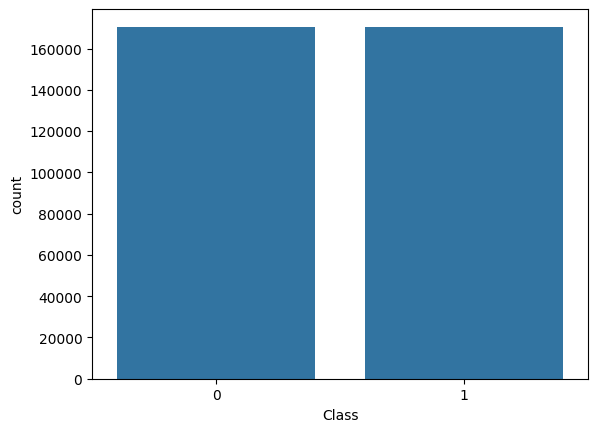

In [30]:
sns.countplot(x=y_train_res)

plt.show()

### BASELINE MODEL WITH LOGISTIC REGRESSION

- Train and fit the model

In [31]:
model_v1 = LogisticRegression()

model_v1.fit(X=X_train_res, y=y_train_res)

y_pred_val = model_v1.predict(X=X_val_scaled)

- Evaluation on the val set

In [32]:
# confusion matrix is not very practical to explain
report = classification_report(y_true=y_val, y_pred=y_pred_val)
cm = confusion_matrix(y_true=y_val, y_pred=y_pred_val)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.90      0.11        99

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962

[[55429  1434]
 [   10    89]]


- Confusion matrix is useless, using the AUPRC

In [33]:
def evaluate_model(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true=y_true, y_score=y_score)
    auprc = auc(recall, precision)
    print(f"AUPRC: {auprc:.4f}")

    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUPRC = {auprc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

- Model evaluation using AUPRC

AUPRC: 0.7765


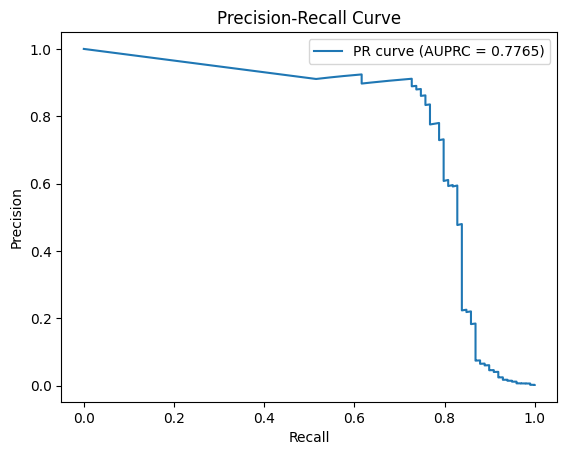

In [38]:
# get the fraud probability, all rows, but get the second probability
y_score = model_v1.predict_proba(X_val_scaled)[:, 1]
evaluate_model(y_val, y_score)

### TRY WITH XGBOOT MODEL

In [45]:
model_v2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42,
)

model_v2.fit(X_train_res, y_train_res)
y_pred_val = model_v2.predict(X_val_scaled)

- Model evaluation with confusion matrix

In [43]:
# confusion matrix is not very practical to explain
report = classification_report(y_true=y_val, y_pred=y_pred_val)
cm = confusion_matrix(y_true=y_val, y_pred=y_pred_val)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.29      0.86      0.43        99

    accuracy                           1.00     56962
   macro avg       0.64      0.93      0.71     56962
weighted avg       1.00      1.00      1.00     56962

[[56653   210]
 [   14    85]]


- Model evaluation with AUPRC

AUPRC: 0.8330


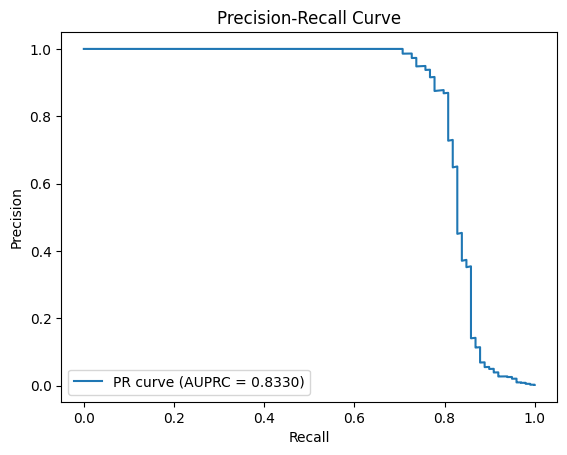

In [44]:
y_score = model_v2.predict_proba(X=X_val_scaled)[:, 1]
evaluate_model(y_val, y_score)

### TRY WITH RANDOM FOREST

In [48]:
model_v3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

model_v3.fit(X=X_train_res, y=y_train_res)

y_pred_val = model_v3.predict(X=X_val_scaled)

- Model evaluation with confusion matrix

In [49]:
# confusion matrix is not very practical to explain
report = classification_report(y_true=y_val, y_pred=y_pred_val)
cm = confusion_matrix(y_true=y_val, y_pred=y_pred_val)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.95      0.97        99

    accuracy                           1.00     56962
   macro avg       0.99      0.97      0.98     56962
weighted avg       1.00      1.00      1.00     56962

[[56862     1]
 [    5    94]]


- Model avaluation with AUPRC

AUPRC: 0.9637


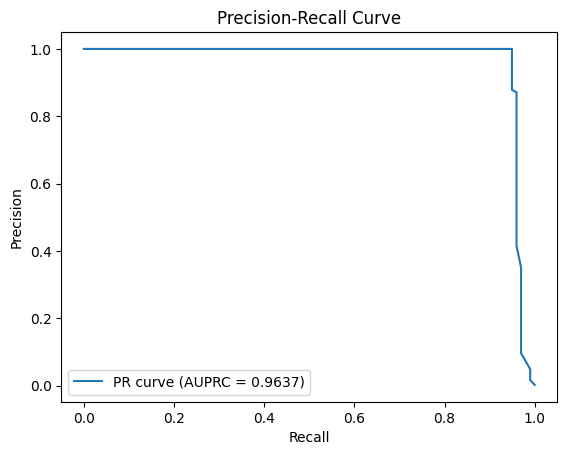

In [50]:
y_score = model_v3.predict_proba(X=X_val_scaled)[:, 1]
evaluate_model(y_val, y_score)

### MERGE TRAIN AND VAL SET INTO A TRAIN SET, APPYING RANDOM FOREST MODEL

- Concatenating the train and val set into a single train set

In [57]:
X_trainval_scaled = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

- Applying the SMOTE technique to handle imbalance dataset

In [58]:
smote_v4 = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_trainval_scaled, y_trainval)

- Retrain the model of RandomForest

In [59]:
model_v4 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

model_v4.fit(X=X_train_res, y=y_train_res)
y_pred = model_v4.predict(X=X_test_scaled)

- Confusion matrix

In [60]:
# confusion matrix is not very practical to explain
report = classification_report(y_true=y_test, y_pred=y_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56850    14]
 [   17    81]]


- Evaluate on AUPRC

AUPRC: 0.8719


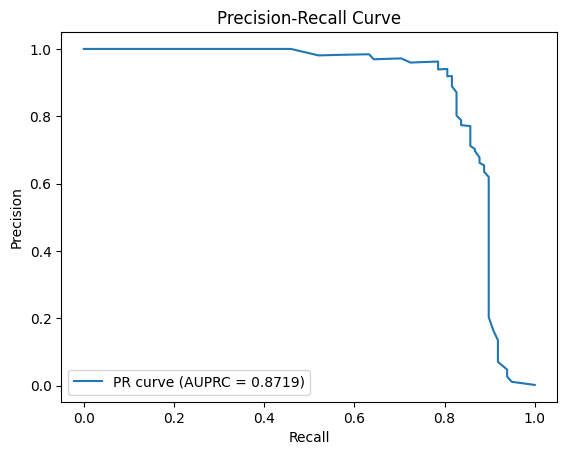

In [61]:
y_score = model_v4.predict_proba(X=X_test_scaled)[:, 1]
evaluate_model(y_test, y_score)